In [1]:
from pipeline import (univariate_data_analysis, load_data, split_data, optimize_model, #compare_models,
split_univariate_sequence, objective, time_series_forecasting, prepare_data_for_optimization, create_optuna_model)
import pandas as pd

C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_filtered, df_info_filtered = load_data()

Info Filtered:
       M4id category  Frequency  Horizon      SP    StartingDate
99623   H38    Other         24       48  Hourly  01-07-15 12:00
99649   H64    Other         24       48  Hourly  01-07-15 12:00
99813  H228    Other         24       48  Hourly  15-05-10 12:00
99860  H275    Other         24       48  Hourly  02-01-10 12:00
99989  H404    Other         24       48  Hourly  06-01-17 12:00

Filtered Data (First Rows):
V1 Step  H404  H275     H64  H228     H38
0    V2  27.0  15.3  2777.0  12.4  3648.0
1    V3  22.0  15.0  2886.0  11.7  3658.0
2    V4  25.0  14.7  2811.0  11.1  3608.0
3    V5  25.0  14.4  2648.0  10.7  3493.0
4    V6  14.0  14.3  2618.0  10.3  3374.0


In [3]:
def index_date(ts):
    starting_date = df_info_filtered[df_info_filtered['M4id'] == ts]['StartingDate'].iloc[0]
    date_range = pd.date_range(start=starting_date, periods=len(df_filtered[ts]), freq='H')
    df_filtered[ts].index = date_range
    return df_filtered[ts].dropna()

ts = index_date('H404')

C:\Users\dosju\AppData\Local\Temp\ipykernel_25616\1019650919.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=starting_date, periods=len(df_filtered[ts]), freq='H')


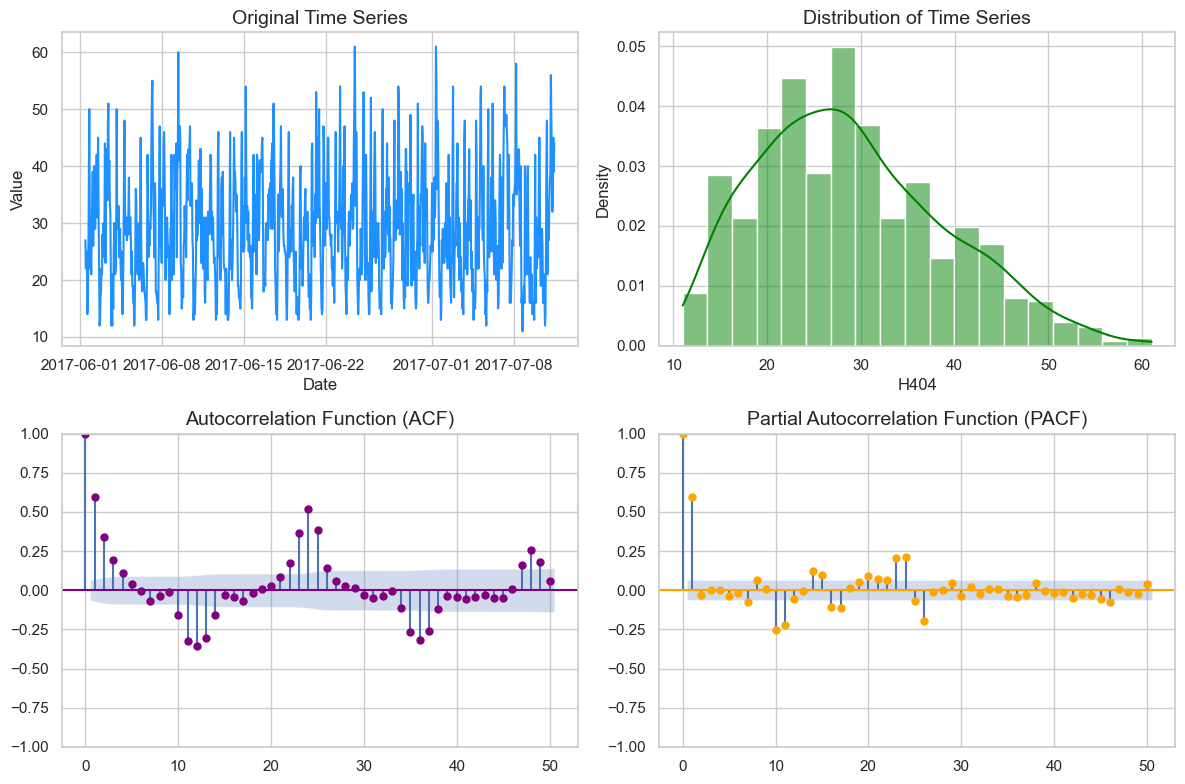

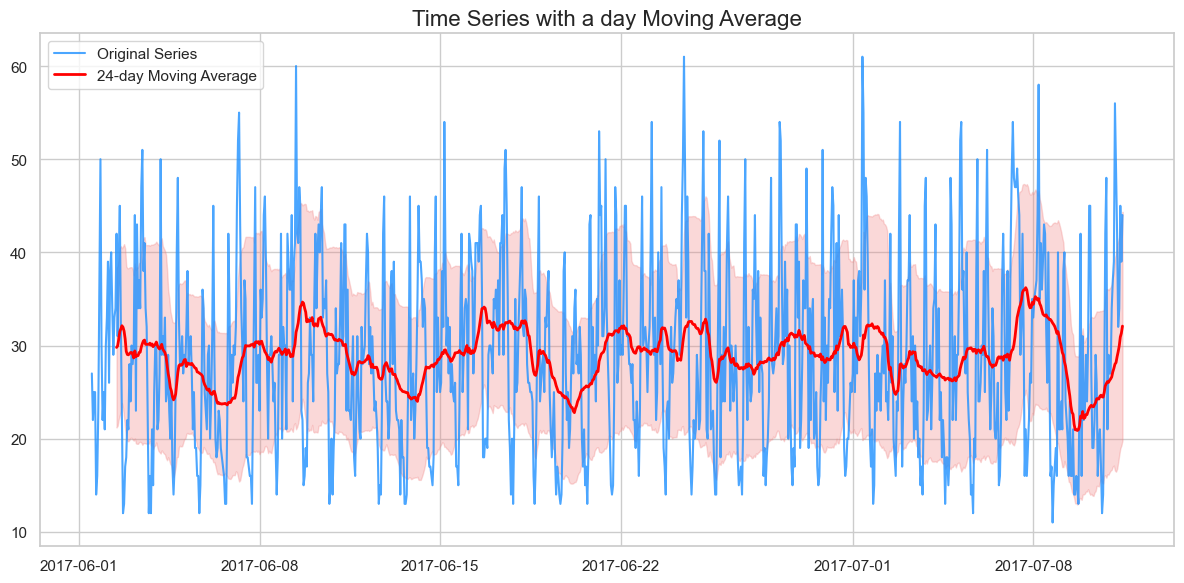

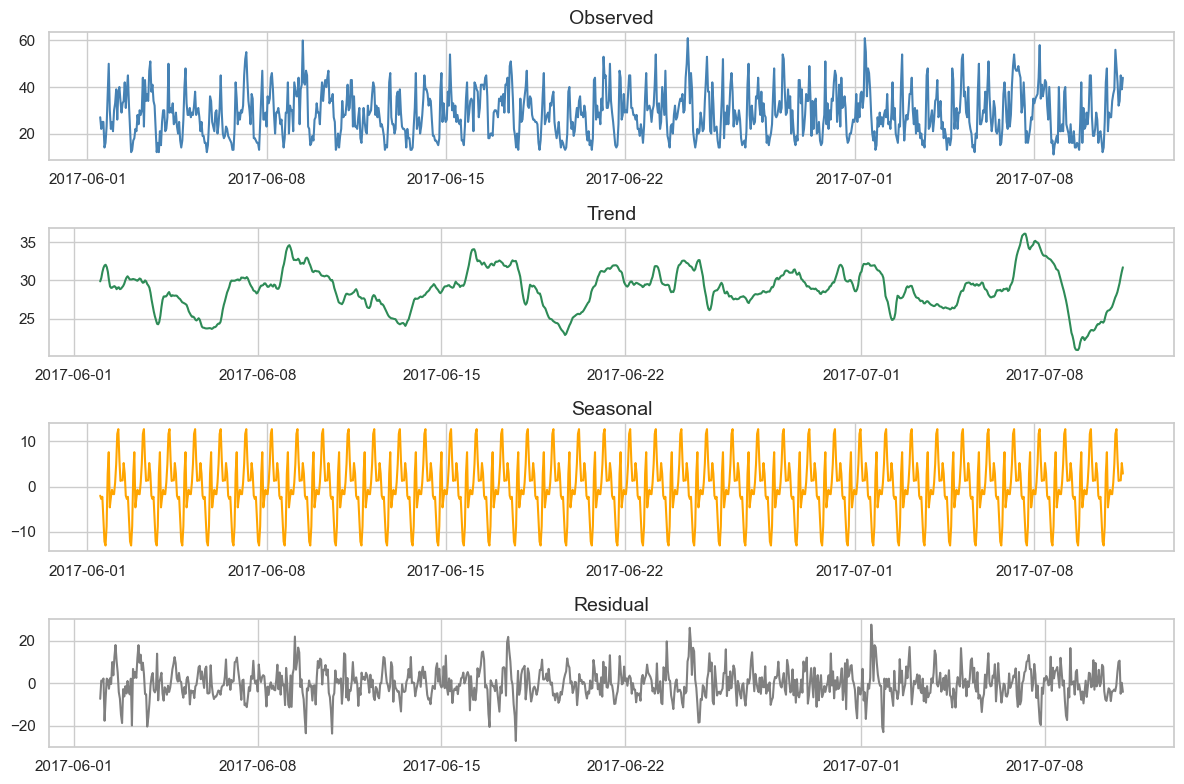

Descriptive Statistics:
count    960.000000
mean      28.957292
std        9.888284
min       11.000000
25%       21.750000
50%       28.000000
75%       35.000000
max       61.000000
Name: H404, dtype: float64

Shapiro-Wilk Test p-value: 8.48481536291411e-13
Interpretation: p < 0.05 suggests the data is not normally distributed

Augmented Dickey-Fuller Test for Stationarity:
ADF Statistic: -4.633431617992736
p-value: 0.00011203167916002643
Interpretation:
p < 0.05: Reject null hypothesis (Series is stationary)
p >= 0.05: Fail to reject null hypothesis (Series might be non-stationary)


In [4]:
univariate_data_analysis(ts)

Train: 624, Validation: 144, Test: 144


C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\s

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
MLP Model 1 MAE: 5.881562765439352
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
MLP Model 2 MAE: 5.845254453023275
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000228EE161080> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
MLP Model 3 MAE: 5.540676172574362
4/4 ━━━━━━━━━━━━

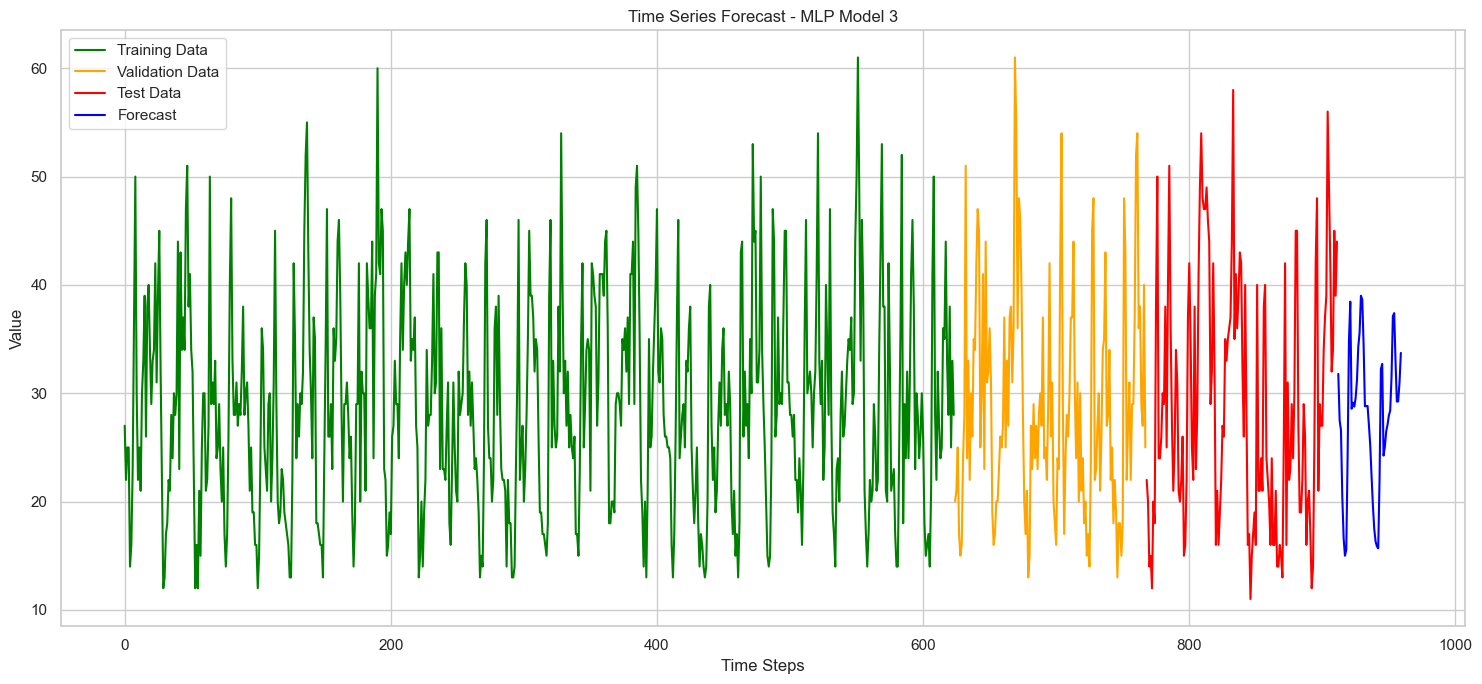

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


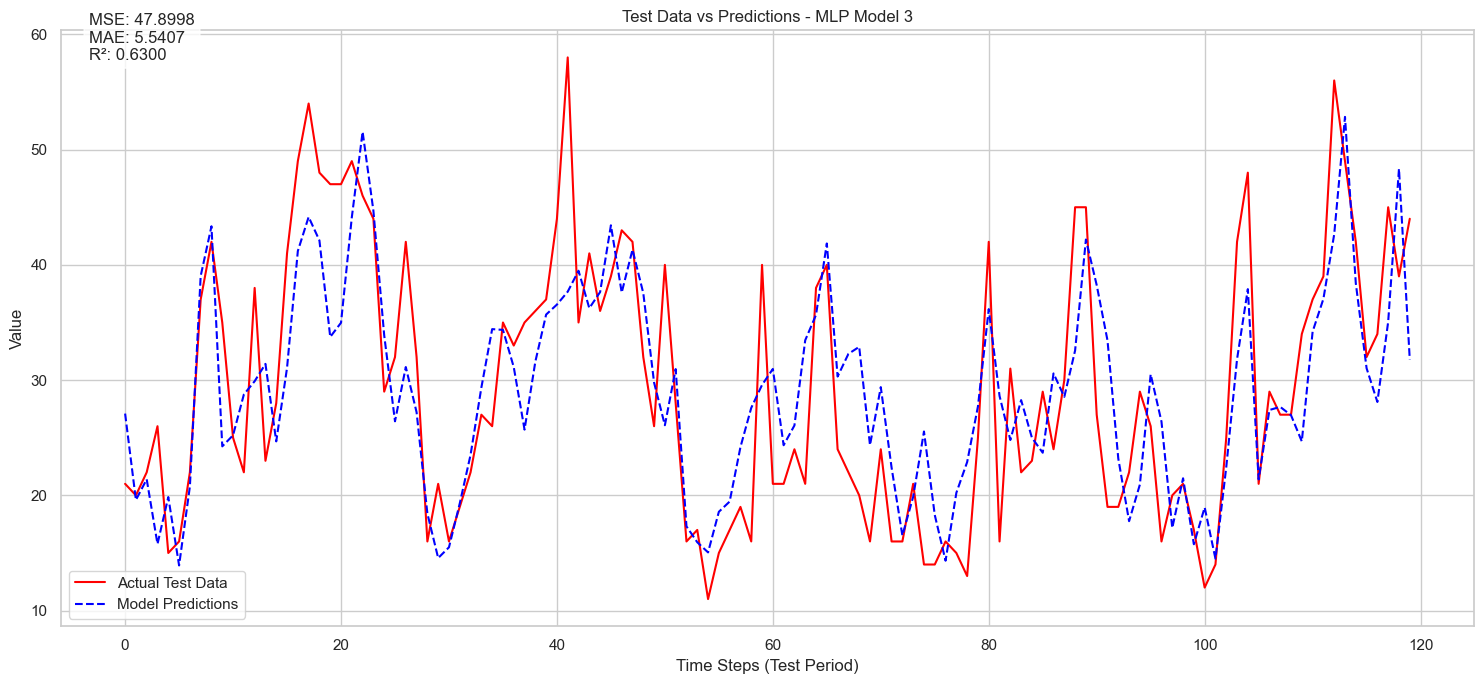


Model Performance Comparison:
      Model Type  Mean Absolute Error
     MLP Model 3             5.540676
     CNN Model 1             5.659458
     MLP Model 2             5.845254
     MLP Model 1             5.881563
CNN-LSTM Model 3             6.080387
    LSTM Model 3             6.164618
    LSTM Model 1             6.192413
    LSTM Model 2             6.299397
CNN-LSTM Model 1             6.377279
     CNN Model 2             6.394774
CNN-LSTM Model 2             6.860690
     CNN Model 3             8.546550


In [5]:
train_data, val_data, test_data = split_data(ts)
best_model = time_series_forecasting(train_data, val_data, test_data)

In [6]:
best_model['best_model'].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

[I 2025-04-03 01:25:44,623] A new study created in memory with name: no-name-3f2f44f1-9bc1-4b01-b146-b87f67e6de47
c:\Users\dosju\Downloads\Examen2NL\pipeline.py:690: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-04-03 01:26:26,635] Trial 0 finished with value: 0.11200647056102753 and parameters: {'optimizer': 'rmsprop', 'learning

Best MLP Model Optimization Results:
  Number of trials: 200
  Best trial value (MAE): 0.09540198743343353
  Best hyperparameters:
    optimizer: rmsprop
    learning_rate: 0.0032123779744211976
    activation: relu
    n_layers: 4
    neurons_0: 190
    neurons_1: 78
    dropout_1: 0.17784155130898066
    neurons_2: 53
    dropout_2: 0.09180453107390942
    neurons_3: 47
    dropout_3: 0.08937649684129227
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━

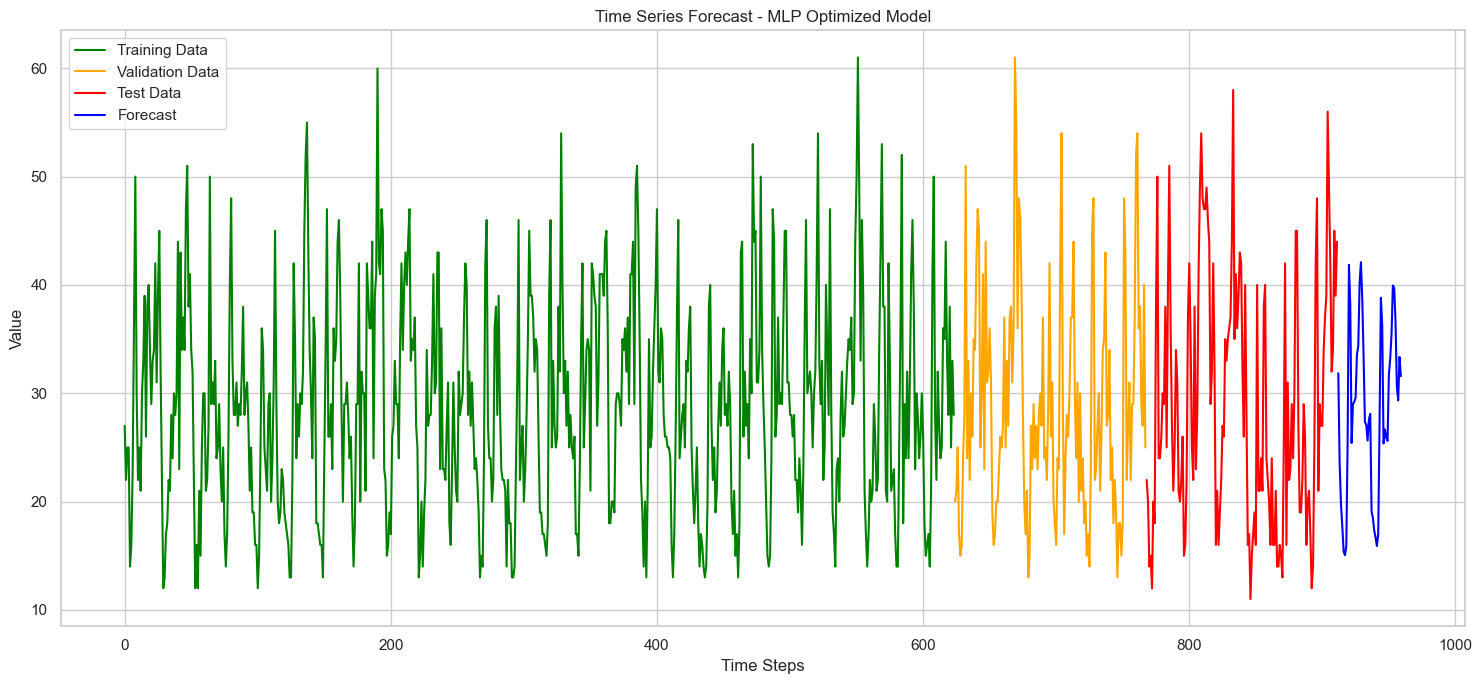


Test Data Prediction Analysis:


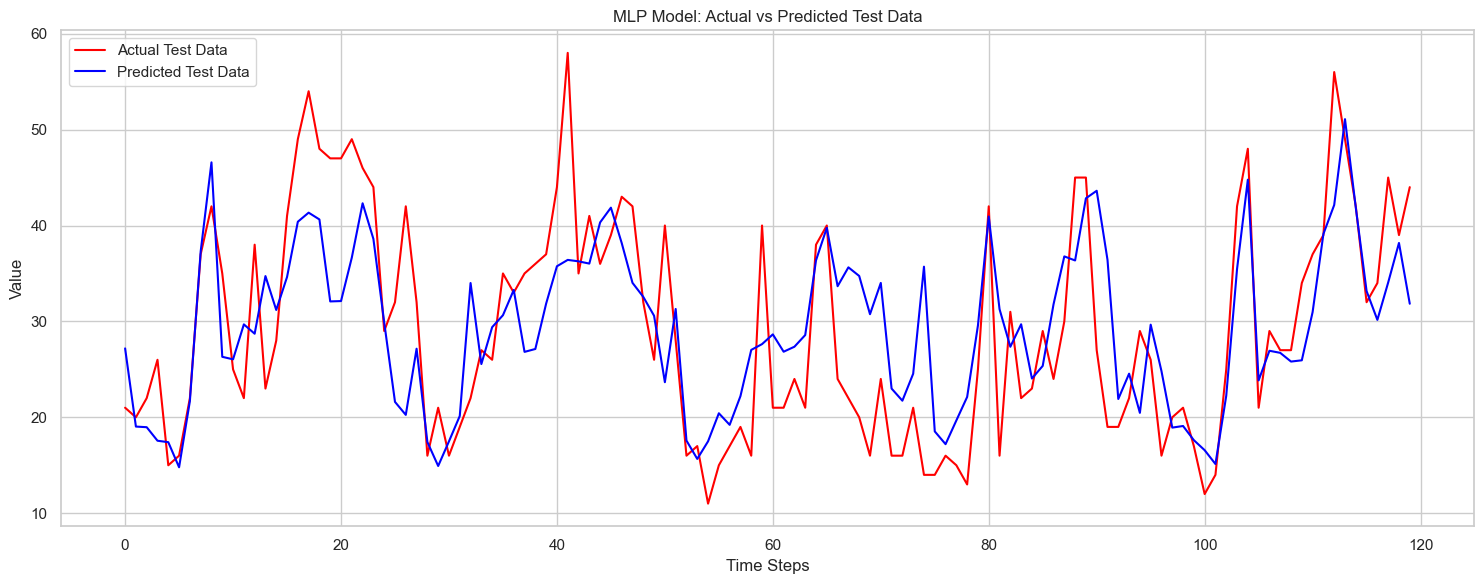


Model Performance Metrics:
Mean Absolute Error (MAE): 6.069634064038595
Mean Squared Error (MSE): 62.20094087733805


In [7]:
result = optimize_model(train_data, val_data, test_data, n_steps=24, model_type='mlp', n_trials=200)
best_model = result['best_model']
best_params = result['best_params']
scaler = result['scaler']